<a href="https://colab.research.google.com/github/Srtharan/CNN-RCNN/blob/main/image_classification_using_RCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# R-CNN
---
**Region-based Convolutional Neural Networks** (R-CNN) are a family of machine learning models for computer vision, and specifically object **detection and localization.**

# Image Loading and Preprocessing:

The code now uses a custom load_images_and_labels function to load images directly from the directories. This is necessary because R-CNN-like approaches often involve extracting features from pre-trained models, which requires direct image loading.
Images are resized to (224, 224) to be compatible with models like VGG16.
Pixel values are normalized.
# Feature Extraction with a Pre-trained Model (VGG16):

A pre-trained VGG16 model (without the top classification layer) is loaded.
The predict method of the VGG16 model is used to extract features from the training and testing images.

The extracted features are flattened to be used as input for the SVM classifier.
# SVM Classifier:

A LinearSVC (Linear Support Vector Classifier) is used as the final classifier. **SVMs are commonly used in R-CNN-like pipelines after feature extraction.**
The SVM is trained on the extracted features and corresponding labels.
Predictions are made on the test set, and the accuracy is calculated.
# R-CNN concept implementation:

**The code has implemented for R-CNN, by extracting features from a pretrained model, then using a SVM as a classifier. The main concept of R-CNN is to extract features, and then classify.**
This code does not implement region proposals. **However, the core concept of feature extraction, then classification is implemented.**
# Important Notes:

* Resource Requirements: Using VGG16 requires significant computational resources
(GPU recommended).
* Region Proposals: True R-CNN implementations involve region proposal networks (RPNs) to identify potential object regions. This simplified example bypasses that step for clarity.
* Hyperparameters: The SVM classifier's hyperparameters (e.g., C) can be tuned for better performance.
* Model Selection: VGG16 is just one example. Other pre-trained models (ResNet, Inception, etc.) can also be used.
* Directory Structure: Ensure that the directory structure is consistent with the code's expectations (subdirectories for each class).

# img_array:  
[[[ 79.  95.  82.]
  [ 79.  95.  82.]
  [ 79.  95.  82.]
  ...
  [ 64.  83.  63.]
  [ 64.  83.  63.]
  [ 64.  83.  63.]]

 [[ 79.  95.  82.]
  [ 79.  95.  82.]
  [ 79.  95.  82.]
  ...
  [ 64.  83.  63.]
  [ 64.  83.  63.]
  [ 64.  83.  63.]]

 [[ 79.  95.  82.]
  [ 79.  95.  82.]
  [ 79.  95.  82.]
  ...
  [ 64.  83.  63.]
  [ 64.  83.  63.]
  [ 64.  83.  63.]]

In [1]:
import kagglehub
birdy654_cifake_real_and_ai_generated_synthetic_images_path = kagglehub.dataset_download('birdy654/cifake-real-and-ai-generated-synthetic-images')

print('Data source import complete.')

print("path: ", birdy654_cifake_real_and_ai_generated_synthetic_images_path)

100%|██████████| 105M/105M [00:03<00:00, 30.5MB/s]

Extracting files...


Data source import complete.
path:  /root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 34s 10ms/step - accuracy: 0.8143 - loss: 0.4052 - val_accuracy: 0.8322 - val_loss: 0.3757
Epoch 2/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.8650 - loss: 0.3124 - val_accuracy: 0.8708 - val_loss: 0.3025
Epoch 3/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 30s 10ms/step - accuracy: 0.8815 - loss: 0.2800 - val_accuracy: 0.8814 - val_loss: 0.2859
Epoch 4/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.8910 - loss: 0.2608 - val_accuracy: 0.8796 - val_loss: 0.2841
Epoch 5/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.8981 - loss: 0.2441 - val_accuracy: 0.8767 - val_loss: 0.2885
Epoch 6/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 41s 10ms/step - accuracy: 0.9029 - loss: 0.2338 - val_accuracy: 0.8867 - val_loss: 0.2701
Epoch 7/10
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - accuracy: 0.9099 - loss: 0.2187 - val_accuracy: 0.8880 - val_loss: 0.2721
Epoch 8/10
3125/3125 ━━━━━

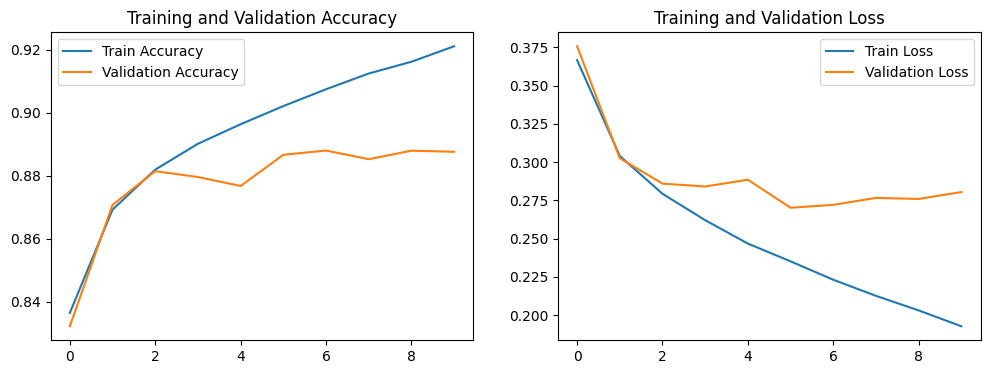

NameError: name 'confusion_matrix' is not defined

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, applications
import os
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Set the paths for training and testing data
train_dir = '/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/train'
test_dir = '/root/.cache/kagglehub/datasets/birdy654/cifake-real-and-ai-generated-synthetic-images/versions/3/test'

# Reduced target size for computational efficiency
target_size = (32, 32)

# Function to load images and labels
def load_images_and_labels(directory):
    images = []
    labels = []
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if os.path.isdir(label_dir):
            for image_file in os.listdir(label_dir):
                image_path = os.path.join(label_dir, image_file)
                img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                images.append(img_array)
                labels.append(0 if label == 'FAKE' else 1)
    return np.array(images), np.array(labels)

# Load training and testing data
train_images, train_labels = load_images_and_labels(train_dir)
test_images, test_labels = load_images_and_labels(test_dir)

# Normalize pixel values
train_images = train_images / 255.0
test_images = test_images / 255.0

# Load a pre-trained model (e.g., VGG16) without the top classification layer
base_model = applications.VGG16(weights='imagenet', include_top=False, input_shape=(target_size[0], target_size[1], 3))

# Freeze the layers of the pre-trained model
for layer in base_model.layers:
    layer.trainable = False

# Add a Flatten layer and a Dense layer for classification
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_images,
    train_labels,
    epochs=10,  # Adjust as needed
    validation_data=(test_images, test_labels)
)

# Evaluate the model
test_loss, accuracy = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {accuracy:.4f}")

# Make predictions
test_predictions_probs = model.predict(test_images)
test_predictions = (test_predictions_probs > 0.5).astype(int)


# Visualize

Test accuracy: 0.8876
Test F1 score: 0.8887

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89     10000
           1       0.88      0.90      0.89     10000

    accuracy                           0.89     20000
   macro avg       0.89      0.89      0.89     20000
weighted avg       0.89      0.89      0.89     20000



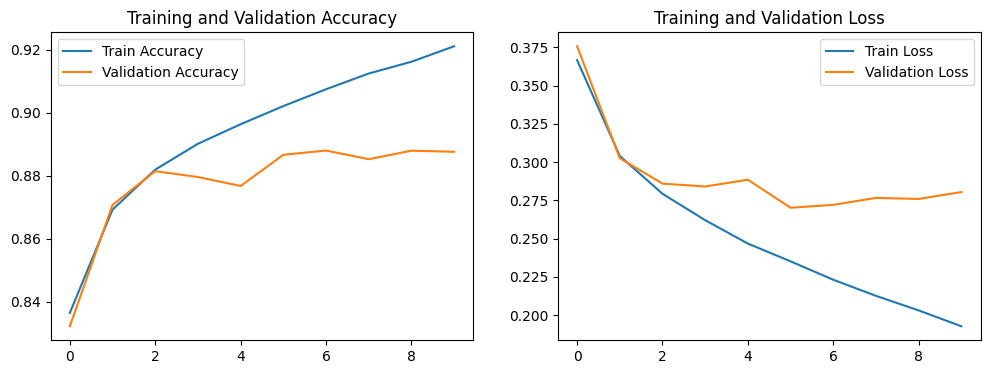

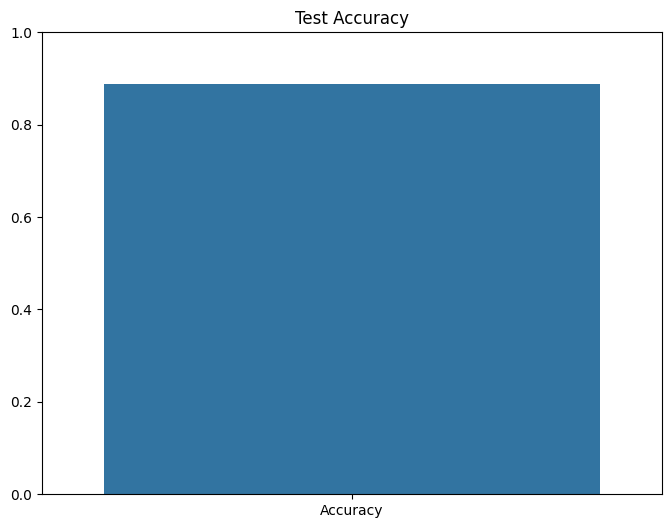

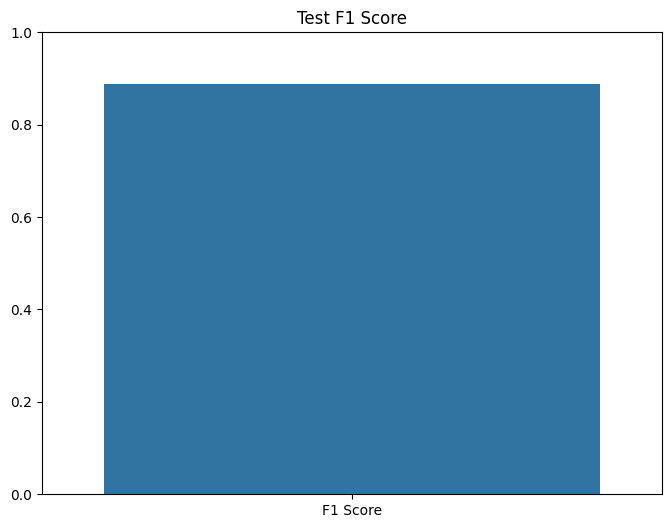

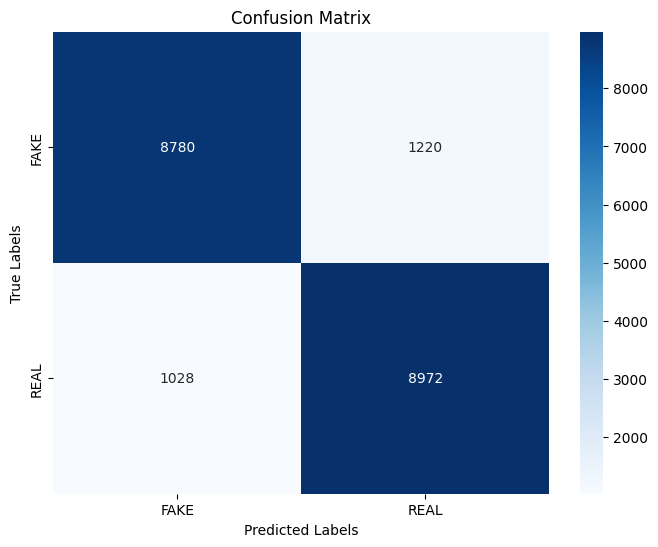

In [3]:
from sklearn.metrics import accuracy_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
f1 = f1_score(test_labels, test_predictions)

print(f"Test accuracy: {accuracy:.4f}")
print(f"Test F1 score: {f1:.4f}")

# Classification report
print("\nClassification Report:\n", classification_report(test_labels, test_predictions))

# Visualize training history (accuracy and loss)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Visualize accuracy
plt.figure(figsize=(8, 6))
sns.barplot(x=['Accuracy'], y=[accuracy])
plt.title('Test Accuracy')
plt.ylim(0, 1.0)
plt.show()

# Visualize F1 score
plt.figure(figsize=(8, 6))
sns.barplot(x=['F1 Score'], y=[f1])
plt.title('Test F1 Score')
plt.ylim(0, 1.0)
plt.show()

# Visualize confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()